In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from collections import deque
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [22]:
import tensorflow as tf
random.seed(123)
np.random.seed(123)
tf.random.set_seed(123)

In [23]:
# Load dataset
df = pd.read_csv("metrics-with-output.csv")
df

,Time,Timestamp,cpu_usage,memory_usage,bandwidth_inbound,bandwidth_outbound,tps,tps_error,response_time,Status
0,2023-09-08 01:16:00,1694110560000,9.00%,53.5%,7.46 GB/s,6.45 GB/s,2 req/s,0 req/s,607 ms,0
1,2023-09-08 01:16:05,1694110565000,16.6%,53.3%,5.85 GB/s,5.27 GB/s,2.20 req/s,0 req/s,2.09 s,0
2,2023-09-08 01:16:10,1694110570000,20.2%,55.3%,9.06 GB/s,7.96 GB/s,3.20 req/s,0 req/s,3.45 s,0
3,2023-09-08 01:16:15,1694110575000,14.6%,58.0%,8.41 GB/s,7.21 GB/s,3.20 req/s,0 req/s,2.58 s,0
4,2023-09-08 01:16:20,1694110580000,10.2%,53.5%,4.88 GB/s,4.30 GB/s,2.60 req/s,0 req/s,862 ms,0
...,...,...,...,...,...,...,...,...,...,...
7184,2023-09-08 11:14:40,1694146480000,22.2%,53.5%,6.52 GB/s,5.67 GB/s,2.40 req/s,0 req/s,1.51 s,0
7185,2023-09-08 11:14:45,1694146485000,27.2%,56.0%,7.37 GB/s,6.49 GB/s,2.60 req/s,0 req/s,1.21 s,0
7186,2023-09-08 11:14:50,1694146490000,7.20%,54.1%,4.76 GB/s,4.02 GB/s,1.40 req/s,0 req/s,285 ms,0
7187,2023-09-08 11:14:55,1694146495000,23.4%,54.6%,6.75 GB/s,5.90 GB/s,2.40 req/s,0 req/s,804 ms,0


In [24]:
# Menampilkan baris pertama dr dataset
df.head()

,Time,Timestamp,cpu_usage,memory_usage,bandwidth_inbound,bandwidth_outbound,tps,tps_error,response_time,Status
0,2023-09-08 01:16:00,1694110560000,9.00%,53.5%,7.46 GB/s,6.45 GB/s,2 req/s,0 req/s,607 ms,0
1,2023-09-08 01:16:05,1694110565000,16.6%,53.3%,5.85 GB/s,5.27 GB/s,2.20 req/s,0 req/s,2.09 s,0
2,2023-09-08 01:16:10,1694110570000,20.2%,55.3%,9.06 GB/s,7.96 GB/s,3.20 req/s,0 req/s,3.45 s,0
3,2023-09-08 01:16:15,1694110575000,14.6%,58.0%,8.41 GB/s,7.21 GB/s,3.20 req/s,0 req/s,2.58 s,0
4,2023-09-08 01:16:20,1694110580000,10.2%,53.5%,4.88 GB/s,4.30 GB/s,2.60 req/s,0 req/s,862 ms,0


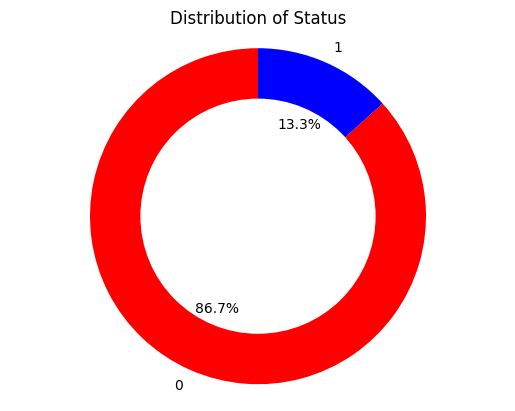

In [25]:
import matplotlib.pyplot as plt

#Membandingkan jumlah status Healthy dan Unhealthy dengan donut chart
status_counts = df['Status'].value_counts()

colors = ['red','blue']
plt.pie(status_counts, labels=status_counts.index, colors=colors, autopct='%1.1f%%', startangle=90)
plt.gca().add_artist(plt.Circle((0,0),0.70,fc='white'))  # Menambahkan lingkaran tengah untuk membuat donut chart
plt.axis('equal')  # Memastikan lingkaran berukuran sama sehingga terlihat seperti donut
plt.title('Distribution of Status')
plt.show()

In [26]:
# Preprocessing data
# Konversi dataset
df['cpu_usage'] = df['cpu_usage'].str.rstrip('%').astype('float') / 100.0
df['memory_usage'] = df['memory_usage'].str.rstrip('%').astype('float') / 100.0
def clean_bandwidth(value):
    if 'GB/s' in value:
        return float(value.replace('GB/s', ''))
    elif 'MB/s' in value:
        return float(value.replace('MB/s', '')) / 1024  # Mengubah MB/s menjadi GB/s
    else:
        return float(value)

df['bandwidth_inbound'] = df['bandwidth_inbound'].apply(clean_bandwidth)
df['bandwidth_outbound'] = df['bandwidth_outbound'].apply(clean_bandwidth)
df['tps'] = df['tps'].str.rstrip(' req/s').astype('float')
df['tps_error'] = df['tps_error'].str.rstrip(' req/s').astype('float')
df['response_time'] = df['response_time'].replace({' ms': '*1e-3', ' s': '*1'}, regex=True).map(pd.eval).astype('float')

In [27]:
# Info dataset mengenai tipe, jumlah kolom dll
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7189 entries, 0 to 7188
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Time                7189 non-null   object 
 1   Timestamp           7189 non-null   int64  
 2   cpu_usage           7189 non-null   float64
 3   memory_usage        7189 non-null   float64
 4   bandwidth_inbound   7189 non-null   float64
 5   bandwidth_outbound  7189 non-null   float64
 6   tps                 7189 non-null   float64
 7   tps_error           7189 non-null   float64
 8   response_time       7189 non-null   float64
 9   Status              7189 non-null   int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 561.8+ KB


In [28]:
# Menampilkan dataset setelah proses konversi dan pembersihan data
print(df)

                     Time      Timestamp  cpu_usage  memory_usage  \
0     2023-09-08 01:16:00  1694110560000      0.090         0.535   
1     2023-09-08 01:16:05  1694110565000      0.166         0.533   
2     2023-09-08 01:16:10  1694110570000      0.202         0.553   
3     2023-09-08 01:16:15  1694110575000      0.146         0.580   
4     2023-09-08 01:16:20  1694110580000      0.102         0.535   
...                   ...            ...        ...           ...   
7184  2023-09-08 11:14:40  1694146480000      0.222         0.535   
7185  2023-09-08 11:14:45  1694146485000      0.272         0.560   
7186  2023-09-08 11:14:50  1694146490000      0.072         0.541   
7187  2023-09-08 11:14:55  1694146495000      0.234         0.546   
7188  2023-09-08 11:15:00  1694146500000      0.310         0.538   

      bandwidth_inbound  bandwidth_outbound  tps  tps_error  response_time  \
0                  7.46                6.45  2.0        0.0          0.607   
1              

In [29]:
# Pembersihan/Penghapusan data yang tidak dipakai
dataset = df.drop(df.columns[[0, 1]], axis=1)

dataset.describe()

,cpu_usage,memory_usage,bandwidth_inbound,bandwidth_outbound,tps,tps_error,response_time,Status
count,7189.000000,7189.000000,7189.000000,7189.000000,7189.000000,7189.000000,7189.000000,7189.000000
mean,0.163090,0.542723,6.318377,5.573617,2.490218,0.170817,1.770724,0.132981
std,0.069272,0.019356,3.193037,2.728239,0.784028,0.548970,1.024615,0.339578
min,0.010000,0.497000,0.056055,0.060645,0.600000,0.000000,0.118000,0.000000
25%,0.118000,0.533000,3.940000,3.540000,2.000000,0.000000,0.952000,0.000000
50%,0.156000,0.539000,5.910000,5.230000,2.400000,0.000000,1.520000,0.000000
75%,0.198000,0.549000,8.310000,7.260000,3.000000,0.000000,2.450000,0.000000
max,1.000000,0.700000,20.400000,17.600000,5.800000,4.600000,7.100000,1.000000


In [30]:
from sklearn.preprocessing import LabelEncoder

# Encode 'Status' column into numeric values
label_encoder = LabelEncoder()
dataset['Status'] = label_encoder.fit_transform(dataset['Status'])

In [31]:
dataset['Status']

0       0
1       0
2       0
3       0
4       0
       ..
7184    0
7185    0
7186    0
7187    0
7188    0
Name: Status, Length: 7189, dtype: int64

In [32]:
# Periksa apakah ada data yang hilang
missing_data = dataset.isnull().sum()
if missing_data.any():
    print("Data terdapat missing values yang perlu diimputasi:")
    print(missing_data)
else:
    print("Tidak ada missing values dalam dataset.")

Tidak ada missing values dalam dataset.


In [33]:
# Split data menjadi features (X) dan target (y)
X = dataset.drop('Status', axis=1)
y = dataset['Status']

In [34]:
# Normalisasi data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [35]:
# Split data menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=123)

In [36]:
# Definisikan Environment Class
class Environment:
    def __init__(self, dataset):
        self.dataset = dataset
        self.num_samples = len(dataset)
        self.current_sample_idx = None  # Set indeks sampel saat ini ke None saat inisialisasi

    def reset(self):
        self.current_sample_idx = 0  # Set ulang indeks sampel saat memulai episode baru
        return self.dataset.iloc[self.current_sample_idx], 0, False

    def step(self, action):
        self.current_sample_idx = (self.current_sample_idx + 1) % self.num_samples
        next_observation = self.dataset.iloc[self.current_sample_idx]
        reward = self.calculate_reward(next_observation, action)  # Hitung reward berdasarkan observasi dan aksi
        done = self.current_sample_idx == 0  # Atur done menjadi True jika mencapai akhir episode
        return next_observation, reward, done

    def calculate_reward(self, observation, action):
        actual_Status = observation['Status']  # Dapatkan nilai aktual dari Status dari observasi
        predicted_Status = action  # Mengasumsikan bahwa aksi adalah prediksi Status oleh agen
        if predicted_Status == actual_Status:
            reward = 1  # Beri reward positif jika prediksi Status cocok dengan Status aktual
        else:
            reward = 0  # Beri reward nol jika prediksi Status tidak cocok dengan Status aktual
        return reward

In [37]:
import tensorflow as tf  # Tambahkan import TensorFlow

# Define the Deep Q-Network agent
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001  # Meningkatkan learning rate sedikit
        self.model = self._build_model()

    def _build_model(self):
        model = tf.keras.models.Sequential()
        model.add(tf.keras.layers.Dense(64, input_dim=self.state_size, activation='relu'))
        model.add(tf.keras.layers.Dense(128, activation='relu'))
        model.add(tf.keras.layers.Dense(64, activation='relu'))
        model.add(tf.keras.layers.Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate))
        return model


    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [38]:
# Parameters
num_actions = 2  # Number of possible actions
num_features = len(dataset.columns) - 1  # Number of features in the dataset (excluding classification)
batch_size = 40
num_episodes = 1900
max_steps = 2000

In [39]:
# Initialize environment and agent
env = Environment(dataset)
agent = DQNAgent(state_size=num_features, action_size=num_actions)

In [40]:
# Training loop
total_reward_all = 0
for episode in range(num_episodes):
    state, _, _ = env.reset()  # Reset the environment and get initial state
    total_reward = 0
    done = False
    while not done:
        action = agent.act(state)
        next_state, reward, done = env.step(action)  # Take action and get next state, reward, and done status
        agent.remember(state, action, reward, next_state, done)  # Remember the experience
        state = next_state  # Update the current state
        total_reward += reward  # Accumulate total reward for the episode
    total_reward_all += total_reward
    print("Episode:", episode+1, "of", num_episodes, "Total Reward:", total_reward)

Episode: 1 of 1900 Total Reward: 3567
Episode: 2 of 1900 Total Reward: 3566
Episode: 3 of 1900 Total Reward: 3626
Episode: 4 of 1900 Total Reward: 3629
Episode: 5 of 1900 Total Reward: 3604
Episode: 6 of 1900 Total Reward: 3608
Episode: 7 of 1900 Total Reward: 3664
Episode: 8 of 1900 Total Reward: 3575
Episode: 9 of 1900 Total Reward: 3539
Episode: 10 of 1900 Total Reward: 3623
Episode: 11 of 1900 Total Reward: 3560
Episode: 12 of 1900 Total Reward: 3546
Episode: 13 of 1900 Total Reward: 3557
Episode: 14 of 1900 Total Reward: 3567
Episode: 15 of 1900 Total Reward: 3616
Episode: 16 of 1900 Total Reward: 3548
Episode: 17 of 1900 Total Reward: 3621
Episode: 18 of 1900 Total Reward: 3584
Episode: 19 of 1900 Total Reward: 3618
Episode: 20 of 1900 Total Reward: 3538
Episode: 21 of 1900 Total Reward: 3654
Episode: 22 of 1900 Total Reward: 3643
Episode: 23 of 1900 Total Reward: 3552
Episode: 24 of 1900 Total Reward: 3571
Episode: 25 of 1900 Total Reward: 3621
Episode: 26 of 1900 Total Reward: 

In [41]:
# Calculate average reward
average_reward = total_reward_all / num_episodes
print("Average reward:", average_reward)

Average reward: 3594.924736842105


In [42]:
# Function to predict Status
def predict_status(observation, agent):
    state = observation.values[:-1]  # Menggunakan fitur dari observasi sebagai state
    state = np.reshape(state, (1, len(state)))  # Reshape state menjadi bentuk (1, num_features)
    action = agent.act(state)  # Prediksi tindakan menggunakan agen
    return action  # Mengembalikan aksi sebagai prediksi Status

In [43]:
# Contoh prediksi Status berdasarkan observasi ke-10 dari dataset
observation = dataset.iloc[10]  # Ambil observasi ke-10 dari dataset
predicted_status = predict_status(observation, agent)  # Prediksi Status menggunakan fungsi predict_status
actual_status = observation['Status']  # Status yang sebenarnya dari observasi dalam dataset
print("Predicted Status for observation 10:", predicted_status)
print("Actual Status for observation 10:", actual_status)

Predicted Status for observation 10: 0
Actual Status for observation 10: 0.0


In [44]:
# Fungsi untuk hitung akurasi
def calculate_accuracy(dataset, agent):
    correct_predictions = 0
    total_predictions = len(dataset)

    for index, observation in dataset.iterrows():
        state = observation.values[:-1]  # Menggunakan fitur dari observasi sebagai state
        state = np.reshape(state, (1, len(state)))  # Pastikan state di-reshape ke bentuk (1, num_features)
        predicted_Status = agent.act(state)  # Prediksi Status menggunakan agen
        actual_Status = observation['Status']  # Nilai Status aktual dari dataset
        if predicted_Status == actual_Status:
            correct_predictions += 1

    accuracy = (correct_predictions / total_predictions) * 100
    return accuracy


In [45]:
# Menggunakan fungsi calculate_accuracy untuk menghitung akurasi
accuracy = calculate_accuracy(dataset, agent)
print("Accuracy:", accuracy, "%")

Accuracy: 49.49227987202671 %


In [46]:
# Membuat list untuk menyimpan hasil prediksi
predicted_labels = []

In [47]:
# Loop melalui setiap observasi dalam dataset dan membuat prediksi
for index, observation in dataset.iterrows():
    predicted_status = predict_status(observation, agent)  # Melakukan prediksi Status
    predicted_labels.append(predicted_status)

In [48]:
# Membuat DataFrame dari list hasil prediksi
predicted_labels_df = pd.DataFrame(predicted_labels, columns=['Status'])

In [49]:
# Output hasil prediksi dalam format yang diminta
print(predicted_labels_df)

      Status
0          0
1          0
2          0
3          0
4          1
...      ...
7184       1
7185       1
7186       0
7187       0
7188       1

[7189 rows x 1 columns]


In [50]:
# Gabungkan kolom Status dari dataset asli dengan kolom Status dari predicted_labels_df
comparison_df = pd.concat([dataset['Status'], predicted_labels_df['Status']], axis=1)
comparison_df.columns = ['Actual_Status', 'Predicted_Status']

In [51]:
# Hitung jumlah status yang sama dan yang berbeda
same_status = comparison_df[comparison_df['Actual_Status'] == comparison_df['Predicted_Status']].shape[0]
different_status = comparison_df[comparison_df['Actual_Status'] != comparison_df['Predicted_Status']].shape[0]

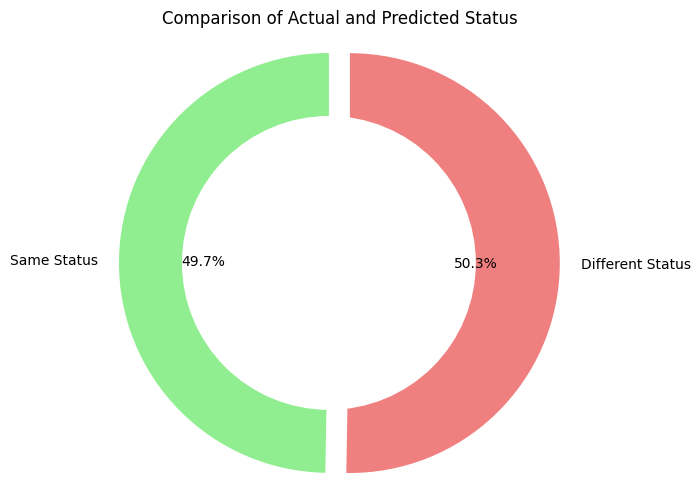

In [52]:
# Buat visualisasi
plt.figure(figsize=(8, 6))
labels = ['Same Status', 'Different Status']
sizes = [same_status, different_status]
colors = ['lightgreen', 'lightcoral']
explode = (0, 0.1)  # Pisahkan "Different Status"
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.gca().add_artist(plt.Circle((0,0),0.70,fc='white'))  # Menambahkan lingkaran tengah untuk membuat donut chart
plt.axis('equal')  # Memastikan lingkaran berukuran sama sehingga terlihat seperti donut
plt.title('Comparison of Actual and Predicted Status')
plt.show()

In [53]:
import matplotlib.pyplot as plt

# Hitung jumlah status 0 dan 1 dari predicted_labels_df
healthy_count = predicted_labels_df[predicted_labels_df['Status'] == 0].shape[0]
unhealthy_count = predicted_labels_df[predicted_labels_df['Status'] == 1].shape[0]

In [54]:
# Data untuk plot
status_labels = ['0', '1']
status_counts = [healthy_count, unhealthy_count]

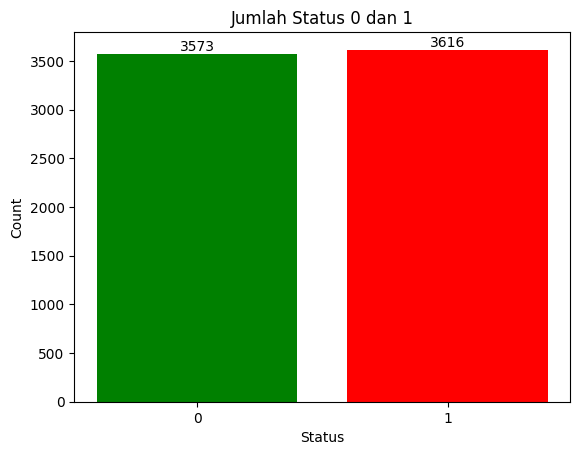

In [55]:
# Plot batang
plt.bar(status_labels, status_counts, color=['green', 'red'])

# Tambahkan label angka di atas setiap batang
for i in range(len(status_labels)):
    plt.text(i, status_counts[i], str(status_counts[i]), ha='center', va='bottom')

# Label sumbu dan judul
plt.xlabel('Status')
plt.ylabel('Count')
plt.title('Jumlah Status 0 dan 1')

# Tampilkan plot
plt.show()

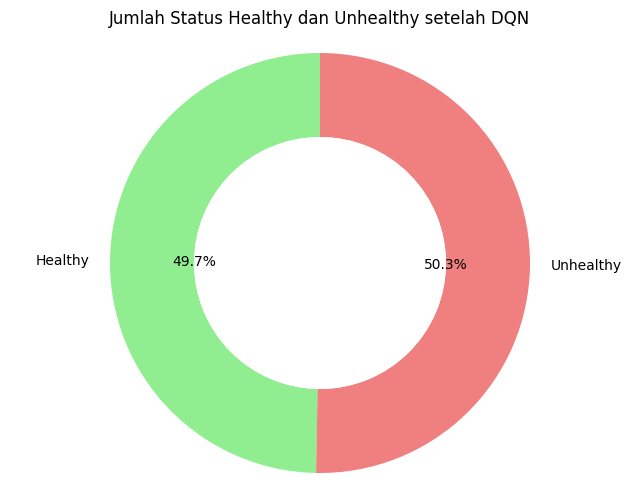

In [56]:
import matplotlib.pyplot as plt
# s
# Hitung jumlah status 0 dan 1 dari predicted_labels_df
healthy_count = predicted_labels_df[predicted_labels_df['Status'] == 0].shape[0]
unhealthy_count = predicted_labels_df[predicted_labels_df['Status'] == 1].shape[0]

# Data untuk plot
status_labels = ['Healthy', 'Unhealthy']
status_counts = [healthy_count, unhealthy_count]
colors = ['lightgreen', 'lightcoral']

# Plot donut chart
plt.figure(figsize=(8, 6))
plt.pie(status_counts, labels=status_labels, colors=colors, autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.4))
plt.gca().add_artist(plt.Circle((0, 0), 0.6, fc='white'))  # Menambahkan lingkaran tengah untuk membuat donut chart
plt.axis('equal')  # Memastikan lingkaran berukuran sama sehingga terlihat seperti donut
plt.title('Jumlah Status Healthy dan Unhealthy setelah DQN')
plt.show()

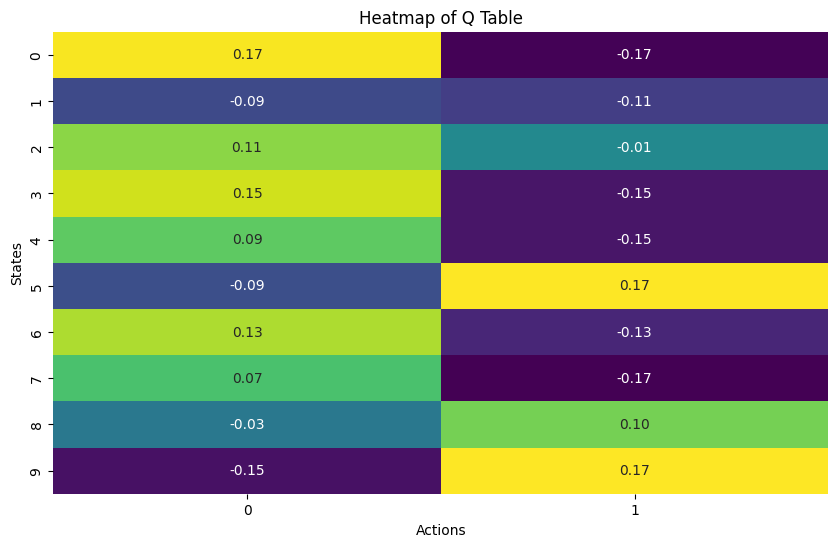

In [57]:
# Menampilkan heatmap dari tabel Q
import seaborn as sns

# Dapatkan bobot dari model jaringan saraf
def get_q_table(model, num_actions):
    # Ambil layer ke-2 (indeks 1) dari model, yang merupakan layer pertama setelah input
    first_layer = model.layers[1]
    # Dapatkan bobot dari layer
    weights = first_layer.get_weights()[0]
    # Ubah bobot menjadi format yang sesuai untuk tabel Q
    q_table = weights.reshape((-1, num_actions))
    return q_table

# Fungsi untuk menampilkan heatmap dari tabel Q
def plot_q_table_heatmap(q_table):
    plt.figure(figsize=(10, 6))
    sns.heatmap(q_table, cmap='viridis', annot=True, fmt=".2f", cbar=False)
    plt.xlabel('Actions')
    plt.ylabel('States')
    plt.title('Heatmap of Q Table')
    plt.show()

# Dapatkan tabel Q dari model agen
q_table = get_q_table(agent.model, num_actions)

# Reduksi dimensi state labels menjadi 1-10
state_labels_reduced = ['State {}'.format(i+1) for i in range(10)]

# Ambil subset dari q_table untuk hanya menampilkan 10 state pertama
q_table_subset = q_table[:10]

# Tampilkan heatmap dari tabel Q
plot_q_table_heatmap(q_table_subset)

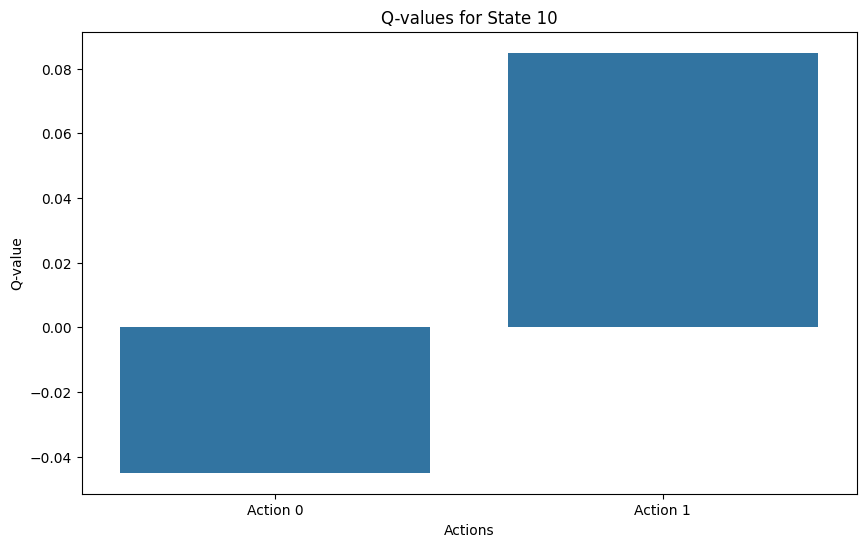

In [58]:
# Pilih state yang ingin divisualisasikan, misalnya state ke-10
state_index = 10

# Dapatkan Q-values untuk state tersebut
q_values = q_table[state_index, :]

# Tentukan actions (dalam kasus Anda, hanya 2 actions)
actions = ['Action 0', 'Action 1']

# Plot barplot dari Q-values
plt.figure(figsize=(10, 6))
sns.barplot(x=actions, y=q_values)
plt.title(f'Q-values for State {state_index}')
plt.xlabel('Actions')
plt.ylabel('Q-value')
plt.show()